In [48]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

In [26]:
BASE_DIR = "E:\\Support Projects\\Retail_Items_Forecasting"
                              
# Loading the Data  
ra_02_df = pd.read_excel(BASE_DIR+"/Data/02 RA data (updated Apr'21) raw data only.xlsx") #01 RA raw data final.xlsx

sku_mapping = pd.read_csv(BASE_DIR+'/Data/07 mapping table (active SKU).csv')

sku_mapping = sku_mapping.drop_duplicates(['Brand House',
                                           'RA raw data (file 01 & 02)',
                                           'KA data (file 04)'])

print("Total data in ra 02 file -", ra_02_df.shape)

print("Total data in sku_mapping file -", sku_mapping.shape)


Total data in ra 02 file - (39650, 15)
Total data in sku_mapping file - (87, 5)


In [30]:
ra_02_df.head()

,State,Region,Channel_Mod,Channel Breakdown,SKU,Price Segment,Brand House,Manufacturer,Tar x Flavour,Tar x Flavour with Kretek,Price x Tar,Month,Volume,Value,Unnamed: 14
0,Ipoh,NORTH,KAD,KAD,BENSON & HEDGES,PREMIUM,Benson & Hedges,BAT,Full Flavour,Full Flavour,Premium x Full Flavour,2020-01-01,124.677,108.46899,NaN
1,Ipoh,NORTH,KAD,KAD,CHESTERFIELD BLUE,VFM,Chesterfield,PMI,Lights,Lights,Vfm x Lights,2020-01-01,172.320,106.83840,NaN
2,Ipoh,NORTH,KAD,KAD,CHESTERFIELD CHARCOAL,VFM,Chesterfield,PMI,Lights,Lights,Vfm x Lights,2020-01-01,102.977,63.84574,NaN
3,Ipoh,NORTH,KAD,KAD,CHESTERFIELD GREEN,VFM,Chesterfield,PMI,Menthol,Menthol,Vfm x Menthol,2020-01-01,139.161,86.27982,NaN
4,Ipoh,NORTH,KAD,KAD,CHESTERFIELD PURPLE CAPSULE,VFM,Chesterfield,PMI,Menthol,Menthol,Vfm x Menthol,2020-01-01,73.635,45.65370,NaN


In [31]:
ra_02_df.isnull().sum()

State                            0
Region                           0
Channel_Mod                      0
Channel Breakdown                0
SKU                              0
Price Segment                  342
Brand House                    342
Manufacturer                   342
Tar x Flavour                  342
Tar x Flavour with Kretek      342
Price x Tar                    342
Month                            0
Volume                           0
Value                            0
Unnamed: 14                  39650
dtype: int64

In [32]:
# Aggregating the RA 2 data for finding out the others in voluume
# Few SKUs to merge
sku02_to_comb = {'ROTHMANS KOOL':'ROTHMANS KOOL HOKKAIDO MINT',
                 'MARLBORO REGULAR SC':"MARLBORO REGULAR FF",
                 'MARLBORO REGULAR LIGHTS (GOLD)':'MARLBORO LIGHTS'
                }


# combining the skus
ra_02_df['SKU'] = ra_02_df['SKU'].replace(sku02_to_comb)

# 1. Channel should be  KAD
ra_02_kad_df = ra_02_df[ra_02_df['Channel_Mod'] == 'MASS MARKET']

# # 2 Data should be of 2020
# ra_02_kad_df = ra_02_kad_df[(ra_02_kad_df['Month']>='2020-01-01') & 
#                              (ra_02_kad_df['Month']<='2020-12-01')
#                             ].reset_index(drop=True)

ra_agg_df = ra_02_kad_df.groupby(['State', 
                                  'SKU',
                                  'Brand House',
                                  'Manufacturer',
                                  'Month']).agg({'Volume':'sum', 'Value':'sum'}).reset_index()

ra_agg_df.columns = ['State', 
                     'sku', 
                     'brand_house', 
                     'company', 
                     'time', 
                     'total_vol',
                     'total_value']

print("Shape of the data in RA: ", ra_agg_df.shape)

ra_agg_df.head()

Shape of the data in RA:  (9920, 7)


,State,sku,brand_house,company,time,total_vol,total_value
0,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-01-01,437.93661,381.00489
1,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-02-01,457.87942,398.35511
2,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-03-01,449.67307,391.21555
3,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-05-01,438.10797,381.15391
4,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-06-01,445.15705,387.28662


In [33]:
# Because the data is not available for Apr'20
# we are duplicaing for the MAR'20
apr_2020 = ra_agg_df[ra_agg_df['time'] == '2020-03-01'].copy()

print("Unique Values Before Merging")
display(ra_agg_df['time'].unique())


# changing just the date
apr_2020['time'] = '2020-04-01'

apr_2020['time'] = pd.to_datetime(apr_2020['time'], format="%Y-%m-%d")

print(apr_2020['time'].unique())
print(apr_2020.shape)

# Merging with the original data
ra_agg_df = pd.concat([ra_agg_df, apr_2020], 
                      axis=0,
                      ignore_index=True
                     )

print("Unique Values after Merging")
display(ra_agg_df['time'].unique())

print("Shape After Merging")
display(ra_agg_df.shape)

Unique Values Before Merging


array(['2020-01-01T00:00:00.000000000', '2020-02-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-05-01T00:00:00.000000000',
       '2020-06-01T00:00:00.000000000', '2020-07-01T00:00:00.000000000',
       '2020-08-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
       '2020-10-01T00:00:00.000000000', '2020-11-01T00:00:00.000000000',
       '2020-12-01T00:00:00.000000000', '2021-01-01T00:00:00.000000000',
       '2021-02-01T00:00:00.000000000', '2021-03-01T00:00:00.000000000',
       '2021-04-01T00:00:00.000000000'], dtype='datetime64[ns]')

['2020-04-01T00:00:00.000000000']
(628, 7)
Unique Values after Merging


array(['2020-01-01T00:00:00.000000000', '2020-02-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-05-01T00:00:00.000000000',
       '2020-06-01T00:00:00.000000000', '2020-07-01T00:00:00.000000000',
       '2020-08-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
       '2020-10-01T00:00:00.000000000', '2020-11-01T00:00:00.000000000',
       '2020-12-01T00:00:00.000000000', '2021-01-01T00:00:00.000000000',
       '2021-02-01T00:00:00.000000000', '2021-03-01T00:00:00.000000000',
       '2021-04-01T00:00:00.000000000', '2020-04-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

Shape After Merging


(10548, 7)

In [34]:
# ra_agg_df.to_csv(BASE_DIR+"/Output/ra02_agg_final.csv", index=False)

In [35]:
# Checking 1:1 mapping of sku betweeen ka and ra file
display(sku_mapping[sku_mapping['RA raw data (file 01 & 02)'].duplicated()])

display(sku_mapping[sku_mapping['KA data (file 04)'].duplicated()])

sku_mapping['cnt_chk'] =  sku_mapping.groupby(['RA raw data (file 01 & 02)',
                             "KA data (file 04)"
                            ])["KA data (file 04)"].transform('size')

sku_mapping['cnt_chk2'] =  sku_mapping.groupby(['KA data (file 04)',
                             "RA raw data (file 01 & 02)"
                            ])["RA raw data (file 01 & 02)"].transform('size')

display(sku_mapping[sku_mapping['cnt_chk'] > 1])
display(sku_mapping[sku_mapping['cnt_chk2'] > 1])

sku_mapping.drop(['cnt_chk', 'cnt_chk2'], axis=1, inplace=True)

,Manufacturer,Brand House,RA raw data (file 01 & 02),KA data (file 04),Remarks
56,JTI,Mevius,NaN,M7 MTH LTS Nova White Slim,NaN
57,JTI,Mevius,NaN,SALEM MTH LTS Nova White,NaN


,Manufacturer,Brand House,RA raw data (file 01 & 02),KA data (file 04),Remarks


,Manufacturer,Brand House,RA raw data (file 01 & 02),KA data (file 04),Remarks,cnt_chk,cnt_chk2


,Manufacturer,Brand House,RA raw data (file 01 & 02),KA data (file 04),Remarks,cnt_chk,cnt_chk2


In [42]:
# Mergig the ra data with SKU mapping files
print(ra_agg_df.shape)

ra2_agg_df = pd.merge(ra_agg_df, sku_mapping, 
                  left_on= ['sku'],
                  right_on=['RA raw data (file 01 & 02)'],
                  how='left'
                 )
print(ra2_agg_df.shape)

ra2_agg_df = ra2_agg_df.drop(['Manufacturer', 'Brand House',  'RA raw data (file 01 & 02)', 'Remarks'],
                           axis=1
                           )
ra2_agg_df.columns = ['state', 
                      'sku',
                      'brand_house',
                      'company', 
                      'time', 
                      'total_vol', 
                      'total_value',
                      'sku_code']
ra2_agg_df.head()

(10548, 7)
(10548, 12)


,state,sku,brand_house,company,time,total_vol,total_value,sku_code
0,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-01-01,437.93661,381.00489,B&H FF
1,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-02-01,457.87942,398.35511,B&H FF
2,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-03-01,449.67307,391.21555,B&H FF
3,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-05-01,438.10797,381.15391,B&H FF
4,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-06-01,445.15705,387.28662,B&H FF


In [43]:
print('Total SKUs - ', ra2_agg_df['sku'].nunique())
print('Total State - ', ra2_agg_df['state'].nunique())
print('Total Company - ', ra2_agg_df['company'].unique())

Total SKUs -  95
Total State -  10
Total Company -  ['BAT' 'PMI' 'JTI']


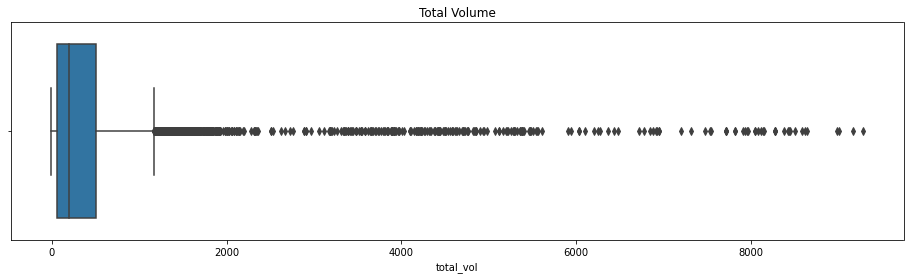

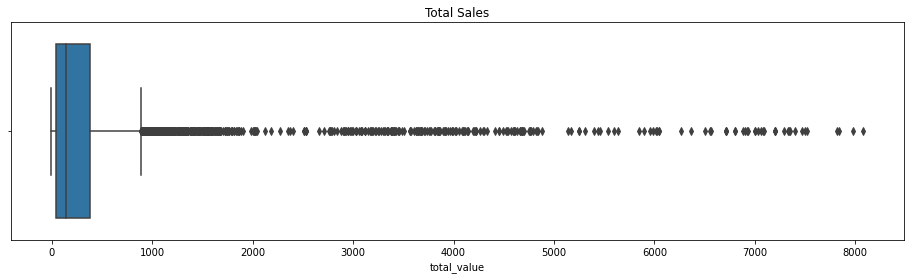

In [53]:
# Do we have 0s in the vol and value
plt.figure(figsize=(16,4))
plt.title("Total Volume")
sns.boxplot(x=ra2_agg_df['total_vol'])
plt.show()

plt.figure(figsize=(16,4))
plt.title("Total Sales")
sns.boxplot(x=ra2_agg_df['total_value'])
plt.show()

In [57]:
# Do we have 0s in the vol and value
ra2_agg_df['total_vol'].describe()

count    10548.000000
mean       433.077281
std        815.055861
min         -5.114160
25%         54.656260
50%        192.291195
75%        501.286522
max       9282.187750
Name: total_vol, dtype: float64

In [58]:
# Do we have 0s in the vol and value
ra2_agg_df['total_value'].describe()

count    10548.000000
mean       342.610638
std        699.583759
min         -4.091330
25%         40.893070
50%        143.965810
75%        380.980635
max       8075.503350
Name: total_value, dtype: float64

In [59]:
# Negative values 
# removing the negative values and less 0 values
print("Before removing the values: ", ra2_agg_df.shape)

ra_02_final_df = ra2_agg_df[(ra2_agg_df['total_value'] > 0) & \
                            (ra2_agg_df['total_vol'] > 0)
                           ]

print("After removing the values: ", ra_02_final_df.shape)

Before removing the values:  (10548, 8)
After removing the values:  (10464, 8)


In [61]:
# Descriptive Stats of value and volume
ra_02_final_df['total_vol'].describe()

count    10464.000000
mean       436.554308
std        817.392873
min          0.206600
25%         56.322245
50%        195.720510
75%        505.425708
max       9282.187750
Name: total_vol, dtype: float64

In [62]:
# Descriptive Stats of value and vol;ume
ra_02_final_df['total_value'].describe()

count    10464.000000
mean       345.361344
std        701.709632
min          0.165280
25%         42.404195
50%        146.519760
75%        383.682240
max       8075.503350
Name: total_value, dtype: float64

In [63]:
ra_02_final_df.head()

,state,sku,brand_house,company,time,total_vol,total_value,sku_code
0,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-01-01,437.93661,381.00489,B&H FF
1,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-02-01,457.87942,398.35511,B&H FF
2,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-03-01,449.67307,391.21555,B&H FF
3,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-05-01,438.10797,381.15391,B&H FF
4,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-06-01,445.15705,387.28662,B&H FF


In [69]:
# Creating new columns
ra_02_final_df['year'] = ra_02_final_df['time'].astype(str).str[0:4].copy()
ra_02_final_df['year'] = ra_02_final_df['year'].astype(int)
print("Unique Year ", ra_02_final_df['year'].unique())

ra_02_final_df['month'] = ra_02_final_df['time'].dt.month.copy()
ra_02_final_df['month'] = ra_02_final_df['month'].astype(int)
print("Unique month ", ra_02_final_df['month'].unique())

ra_02_final_df['uid'] = ra_02_final_df['state'] + "-" + \
ra_02_final_df['sku'] + "-" + \
ra_02_final_df['brand_house'] + "-" +  \
ra_02_final_df['company'] + "-" 

print('No of unique uids - ', ra_02_final_df['uid'].nunique())
ra_02_final_df.head()

Unique Year  [2020 2021]
Unique month  [ 1  2  3  5  6  7  8  9 10 11 12  4]
No of unique uids -  809


<ipython-input-69-bb3988e26759>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ra_02_final_df['year'] = ra_02_final_df['time'].astype(str).str[0:4].copy()
<ipython-input-69-bb3988e26759>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ra_02_final_df['year'] = ra_02_final_df['year'].astype(int)
<ipython-input-69-bb3988e26759>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,state,sku,brand_house,company,time,total_vol,total_value,sku_code,year,month,uid
0,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-01-01,437.93661,381.00489,B&H FF,2020,1,Ipoh-BENSON & HEDGES-Benson & Hedges-BAT-
1,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-02-01,457.87942,398.35511,B&H FF,2020,2,Ipoh-BENSON & HEDGES-Benson & Hedges-BAT-
2,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-03-01,449.67307,391.21555,B&H FF,2020,3,Ipoh-BENSON & HEDGES-Benson & Hedges-BAT-
3,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-05-01,438.10797,381.15391,B&H FF,2020,5,Ipoh-BENSON & HEDGES-Benson & Hedges-BAT-
4,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-06-01,445.15705,387.28662,B&H FF,2020,6,Ipoh-BENSON & HEDGES-Benson & Hedges-BAT-


In [71]:
ra_02_final_df['total_vol'].sum()

4568104.27586

In [73]:
df_ls = ra_02_final_df.copy()
df_ls.head()

,state,sku,brand_house,company,time,total_vol,total_value,sku_code,year,month,uid
0,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-01-01,437.93661,381.00489,B&H FF,2020,1,Ipoh-BENSON & HEDGES-Benson & Hedges-BAT-
1,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-02-01,457.87942,398.35511,B&H FF,2020,2,Ipoh-BENSON & HEDGES-Benson & Hedges-BAT-
2,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-03-01,449.67307,391.21555,B&H FF,2020,3,Ipoh-BENSON & HEDGES-Benson & Hedges-BAT-
3,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-05-01,438.10797,381.15391,B&H FF,2020,5,Ipoh-BENSON & HEDGES-Benson & Hedges-BAT-
4,Ipoh,BENSON & HEDGES,Benson & Hedges,BAT,2020-06-01,445.15705,387.28662,B&H FF,2020,6,Ipoh-BENSON & HEDGES-Benson & Hedges-BAT-


In [78]:
# Creating count columns 
# Ideally it should be 16 from Jan'20 to Apr'21
df_ls['cnt'] = df_ls.groupby(['state',
                              'sku', 
                              'brand_house',
                              'company',
                             ])['uid'].transform('size')
df_ls['cnt'].value_counts()

# Atleast we need 6 months data 
df_ls = df_ls[df_ls['cnt'] >=6]
df_ls.drop('cnt', axis=1, inplace=True)

c:\users\shubham\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [87]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def exp_smoothing_trend(ts,extra_periods=1,alpha=0.4,beta=0.4,phi=0.9):
 
    """
    This function calculates a forecast with an exponential smoothing + damped trend method.
     
    Inputs
      - ts: the historical values (a list, a numpy array or a pandas series)
      - extra_periods: the number of data points that you want to forecast
      - alpha: the level parameter
      - beta: the trend parameter
      - phi: the trend damping parameter
    """
     
    # Avoid any edition of original list, array or dataframe
    ts = ts.copy()
    
    # Transform ts into list
    try:
        ts = ts.tolist()
    except:
        pass  
       
    # Initialization
    f = [np.nan] # First forecast is set to null value
    a = [ts[0]] # First level defined as the first demand point
    b = [ts[1]-ts[0]] # First trend is computed as the difference between the two first demand points
 
    # Create all the m+1 forecast
    for t in range(1,len(ts)):
        # Update forecast based on last level (a) and trend (b)
        f.append(a[t-1]+phi*b[t-1])
        
        # Update the level based on the new data point
        a.append(alpha*ts[t]+(1-alpha)*(a[t-1]+phi*b[t-1]))
         
        # Update the trend based on the new data point
        b.append(beta*(a[t]-a[t-1])+(1-beta)*phi*b[t-1])
         
    # Forecast for all extra months
    for t in range(extra_periods):
        # Update the forecast as the most up-to-date level + trend
        f.append(a[-1]+phi*b[-1])
        # the level equals the forecast
        a.append(f[-1])
        # Update the trend as the previous trend
        b.append(phi*b[-1])
        # fill in ts by np.nan for easy plotting
        ts.append(np.nan)
         
     
    # Populate table with all the results
    dic = {"demand":ts,"forecast":f,"level":a,"trend":b}
    results = pd.DataFrame.from_dict(dic)
    results.index.name = 'Period'
    results["error"] = results["forecast"] - results["demand"] 
        
    # Return the full data set and an indicator of past MAEP    
    return results  


In [79]:
df_ls['uid'].unique()[0]

'Ipoh-BENSON & HEDGES-Benson & Hedges-BAT-'

In [89]:
# #Set the forecast horizon wich is equal to test horizon
h=3
#Running through all the Key Account and PRoductID
final_prediction = pd.DataFrame()

for i in df_ls['uid'].unique():
    print('UID: ', i)
    da = df_ls[df_ls.uid == i].copy()
    da = da.reset_index(drop=True)
    print("Total data shape: ", da.shape)
    

    #Creating Train and test
    data_ts1=da[['total_vol']].reset_index(drop = True)
    data_ts = data_ts1['total_vol']
    train= data_ts[:-h]
    print("Train Shape: ", train.shape)
    test = data_ts[-h:]
    print("Test Shape: ", test.shape)

    #Train the Model and test
    data_pred = exp_smoothing_trend(train,extra_periods=h)

    data_pred['demand'] = data_ts1['total_vol']


    #Calculate performance metrics
    df_per = data_pred.tail(h)
    MSE= mean_squared_error(y_true=df_per['demand'], y_pred=df_per['forecast'])
    MAE= mean_absolute_error(y_true=df_per['demand'], y_pred=df_per['forecast'])
    MAPE= mean_absolute_percentage_error(y_true=df_per['demand'], y_pred=df_per['forecast'])

#         # Creating the model using full data and forecasting n steps  
    data_forcast = exp_smoothing_trend(data_ts,extra_periods=h,alpha=0.4,beta=0.4,phi=0.8)


    data_forcast['uid'] = i
    #Appending Performance metrics to the final frame
    data_forcast['MSE'] = MSE
    data_forcast['MAE'] = MAE
    data_forcast['MAPE'] = MAPE
    data_forcast['Acc'] = 100 - MAPE
    data_forcast = data_forcast.reset_index(drop=True)   

    # Adding te time
    data_forcast['Year'] = da['year'].copy()
    data_forcast['Month'] = da['month'].copy()

#     # Null value index
#     null_values = data_forcast[data_forcast['Month'].isnull()].index
#     print("Null Values ", null_values)
#     count=0

#     for loc in null_values:
#         if data_forcast.loc[loc-1,'Month'] < 12:
#             data_forcast.loc[loc,"Month"] = data_forcast.loc[loc-1,'Month']+1
#             data_forcast.loc[loc,"Year"] = data_forcast.loc[loc-1,"Year"]
#         else:
#             data_forcast.loc[loc,"Month"] = 1+count
#             count=count+1
#             if count == 12:
#                 count=0
#             data_forcast.loc[loc,"Year"] =2021

#     data_forcast['State'] = data_forcast['uid'].apply(lambda x: x.split("-")[0])
#     data_forcast['ACC'] = data_forcast['uid'].apply(lambda x: x.split("-")[1])
#     data_forcast['Company'] = data_forcast['uid'].apply(lambda x: x.split("-")[2])
#     data_forcast['SKU'] = data_forcast['uid'].apply(lambda x: x.split("-")[3])

#     final_prediction = pd.concat([final_prediction, data_forcast],
#                                     axis=0,
#                                     ignore_index=True
#                                    )
    print("-*"*50)


UID:  Ipoh-BENSON & HEDGES-Benson & Hedges-BAT-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Ipoh-BOND STREET BLUE-Bond Street-PMI-
Total data shape:  (7, 11)
Train Shape:  (4,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Ipoh-BOND STREET GREEN-Bond Street-PMI-
Total data shape:  (7, 11)
Train Shape:  (4,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Ipoh-BOND STREET RED-Bond Street-PMI-
Total data shape:  (7, 11)
Train Shape:  (4,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Ipoh-CHESTERFIELD BLUE-Chesterfield-PMI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Ipoh-PETER STUYVESANT PLAIN-Peter Stuyvesant-BAT-
Total data shape:  (15, 11)
Train Shape:  (12,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Ipoh-PETER STUYVESANT RED-Peter Stuyvesant-BAT-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Ipoh-PETER STUYVESANT REMIX VIBE-Peter Stuyvesant-BAT-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Ipoh-ROTHMANS BLUE-Rothmans-BAT-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Johor Baru-MEVIUS FRESH-Mevius-JTI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Johor Baru-MEVIUS MENTHOL WHITE MENTHOL-Mevius-JTI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Johor Baru-MEVIUS ORIGINAL-Mevius-JTI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Johor Baru-MEVIUS REGULAR MENTHOL-Mevius-JTI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kota Baru-L&M FF-L&M-PMI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kota Baru-L&M LIGHTS-L&M-PMI-
Total data shape:  (14, 11)
Train Shape:  (11,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kota Baru-L&M MENTHOL-L&M-PMI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kota Baru-LD CHAI-LD-JTI-
Total data shape:  (15, 11)
Train Shape:  (12,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kota Baru-LD FILTER FF-LD-JTI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shap

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kota Kinabalu-CHESTERFIELD BLUE-Chesterfield-PMI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kota Kinabalu-CHESTERFIELD CHARCOAL-Chesterfield-PMI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kota Kinabalu-CHESTERFIELD GREEN-Chesterfield-PMI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kota Kinabalu-CHESTERFIELD PURPLE CAPSULE-Chesterfield-PMI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kota Kinabalu-SAMPOERNA MILD RED-Sampoerna-PMI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kota Kinabalu-WINSTON BLUE-Winston-JTI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kota Kinabalu-WINSTON DUO LIME-Winston-JTI-
Total data shape:  (7, 11)
Train Shape:  (4,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kota Kinabalu-WINSTON DUO PURPLE (LEP)-Winston-JTI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kota Kinabalu-WINST

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kuala Lumpur-LD ZOOM-LD-JTI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kuala Lumpur-MARLBORO BLACK MENTHOL-Marlboro-PMI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kuala Lumpur-MARLBORO DOUBLE BURST-Marlboro-PMI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kuala Lumpur-MARLBORO ICE BLAST-Marlboro-PMI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kuala Lumpur-MARLBORO LIGHT

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kuantan-DH SWITCH MENTHOL (WITH BEYOND)-Dunhill-BAT-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kuantan-DH ZEST MENTHOL (WITH BEYOND)-Dunhill-BAT-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kuantan-KENT 3 TEK FUTURA BLUE-Kent-BAT-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kuantan-KENT 3 TEK NEO SILVER-Kent-BAT-
Total data shape:  (14, 11)
Train Shape:  (11,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kuantan-KENT RED

Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kuantan-WINSTON DUO PURPLE (LEP)-Winston-JTI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kuantan-WINSTON PLAIN-Winston-JTI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kuantan-WINSTON RED-Winston-JTI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kuantan-WINSTON XS BLUE-Winston-JTI-
Total data shape:  (15, 11)
Train Shape:  (12,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kuching-PALL MALL ICE MENTHOL-Pall Mall-BAT-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kuching-PALL MALL MENTHOL-Pall Mall-BAT-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kuching-PALL MALL MINT MENTHOL-Pall Mall-BAT-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Kuching-PALL MALL RED-Pall Mall-BAT-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

Total data shape:  (7, 11)
Train Shape:  (4,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Melaka-LD PURPLE ZOOM-LD-JTI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Melaka-LD RED FLOW-LD-JTI-
Total data shape:  (7, 11)
Train Shape:  (4,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Melaka-LD ZOOM-LD-JTI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Melaka-MARLBORO BLACK MENTHOL-Marlboro-PMI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Melaka-MARLBORO

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Penang-DH SWITCH MENTHOL (WITH BEYOND)-Dunhill-BAT-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Penang-DH ZEST MENTHOL (WITH BEYOND)-Dunhill-BAT-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Penang-KENT 3 TEK FUTURA BLUE-Kent-BAT-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Penang-KENT 3 TEK NEO SILVER-Kent-BAT-
Total data shape:  (6, 11)
Train Shape:  (3,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Penang-KENT RED-Kent-B

Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Penang-WINSTON PLAIN-Winston-JTI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Penang-WINSTON RED-Winston-JTI-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Penang-WINSTON XS BLUE-Winston-JTI-
Total data shape:  (11, 11)
Train Shape:  (8,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Penang-WINSTON XS DUO FREEZE-Winston-JTI-
Total data shape:  (15, 11)
Train Shape:  (12,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Selangor-BENSON & HE

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Selangor-PALL MALL MENTHOL-Pall Mall-BAT-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Selangor-PALL MALL MINT MENTHOL-Pall Mall-BAT-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Selangor-PALL MALL RED-Pall Mall-BAT-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Selangor-PETER STUYVESANT BLUE-Peter Stuyvesant-BAT-
Total data shape:  (16, 11)
Train Shape:  (13,)
Test Shape:  (3,)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
UID:  Selangor-PETER STUYVE